E-Learning Company Webpage A/B Testing - Part 1
-----------

### Key Project Steps
1. Problem statement
2. Dataset description
3. Data cleaning and wrangling
4. AB testing
5. Regression approach
6. Influence of other factors
7. Recommendation and conclusion

### 1. Problem Statement

**An e-learning company has developed a new web page to try and increase the number of users who enroll in their free data science program (in this context, the enrollment will be referred to as converting). They run an A/B test to understand if they should implement this new page. Further, they also tested this web page separately in three countries - US, UK and Canada to understand if the country of residence plays a role in determining the conversion rate of users. The goal here is to analyze these results and help the company make a decision**

In [2]:
# import relevant libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import random
import statsmodels.api as sm
%matplotlib inline
random.seed(42)

### 2. Dataset Description

In [3]:
df = pd.read_csv('data/part1_results.csv')
df

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB
None


#### 2.1 Preliminary Data Exploration

In [22]:
no_of_rows = len(df)
print(f"No of entries: {no_of_rows}")

no_of_unique_users = df.user_id.nunique()
print(f"No of unique users: {no_of_unique_users}")

no_of_mismatch = len(df.query('group == "treatment" and landing_page != "new_page"')) + len(df.query('group != "treatment" and landing_page == "new_page"'))
print(f"No of times new_page and treatment don't line up: {no_of_mismatch}")

rows_with_na = df.isnull().sum()
print(f"Rows with missing values:\n{rows_with_na}")

No of entries: 294478
No of unique users: 290584
No of times new_page and treatment don't line up: 3893
Rows with missing values:
user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64


### 3. Data Cleaning and Wrangling

In [37]:
# create a new dataframe, ignoring entries from the original dataset
# where treatment and new page do not align
df2 = df[((df.group == 'treatment') & (df.landing_page == 'new_page')) | ((df.group == 'control') & (df.landing_page == 'old_page'))]

# double check that there are no misaligned entries
no_of_mismatch_df2 = len(df2.query('group == "treatment" and landing_page != "new_page"')) + len(df2.query('group != "treatment" and landing_page == "new_page"'))
print(f"No of times new_page and treatment don't line up in the new dataframe: {no_of_mismatch_df2}")

# no of entries in the new dataframe
no_of_rows_df2 = len(df2)
print(f"No of entries in the new dataframe: {no_of_rows_df2}")

# check for duplicate users
no_of_unique_users_df2 = df2.user_id.nunique()
print(f"No of unique users in the new dataframe: {no_of_unique_users_df2}")
print(f"No of duplicate users in the new dataframe: {no_of_rows_df2 - no_of_unique_users_df2}")

# find the duplicate user and drop him
dup_user = df2[df2['user_id'].duplicated()].user_id
print(f"Duplicate user id: {dup_user}")
df2.drop_duplicates(subset=['user_id'], inplace=True, keep = 'first')

# no of entries in the new dataframe after dropping duplicate users
no_of_rows_df2_after_drop = len(df2)
print(f"No of entries in the new dataframe after dropping duplicate users: {no_of_rows_df2_after_drop}")

No of times new_page and treatment don't line up in the new dataframe: 0
No of entries in the new dataframe: 290585
No of unique users in the new dataframe: 290584
No of duplicate users in the new dataframe: 1
Duplicate user id: 2893    773192
Name: user_id, dtype: int64
No of entries in the new dataframe after dropping duplicate users: 290584


### 4. AB Testing

#### 4.1 Probabillities and Conversion Rates

In [39]:
# overall conversion rate irrespective of page
convert_prob_overall = df2['converted'].mean()
print(f"Overall conversion rate irrespective of page: {convert_prob_overall}")

# control group conversion rate
convert_prob_control = df2['user_id'][(df2['converted']==1) & (df2['group']=='control')].count() / df2['user_id'][(df2['group']=='control')].count()
print(f"Control group conversion rate: {convert_prob_control}")

# treatment group conversion rate
convert_prob_treatment = df2['user_id'][(df2['converted']==1) & (df2['group']=='treatment')].count() / df2['user_id'][(df2['group']=='treatment')].count()
print(f"Treatment group conversion rate: {convert_prob_treatment}")

# probability that the individual received the new page
prob_new_page = df2['user_id'][(df2['group']=='treatment')].count() / df2['user_id'].count()
print(f"Probability that the individual received the new page: {prob_new_page}")

Overall conversion rate irrespective of page: 0.11959708724499628
Control group conversion rate: 0.1203863045004612
Treatment group conversion rate: 0.11880806551510564
Probability that the individual received the new page: 0.5000619442226688


#### 4.2 Hypothesis Formulation

Under the null, p_new and p_old are equal to the overall conversion rate (irrespective of the page). Therefore the null and alternate hypothesis can formulated as follows:

* **Null Hypothesis: The conversion rate of the old and new page is the same and is equal to the overall conversion rate**

* **Alternate Hypothesis: There is a difference in conversion rates between the old and new pages**

In [43]:
# conversion rates p_new under the null
p_new = convert_prob_overall
print(f"Conversion rates of the new page under the null: {p_new}")

# conversion rates p_old under the null
p_old = convert_prob_overall
print(f"Conversion rates of the old page under the null: {p_old}")

# number of individuals in the treatment group
n_new = len(df2[df2.group=='treatment'])
print(f"Number of individuals in the treatment group: {n_new}")

# number of individuals in the control group
n_old = len(df2[df2.group=='control'])
print(f"Number of individuals in the treatment group: {n_old}")

Conversion rates of the new page under the null: 0.11959708724499628
Conversion rates of the old page under the null: 0.11959708724499628
Number of individuals in the treatment group: 145310
Number of individuals in the treatment group: 145274


In [53]:
# simulate n_new transactions with a conversion rate of p_new under the null
sim_new_page_converted = np.random.choice(2, size=n_new, p=[1-p_new, p_new]).mean()
print(f"Simulated conversion rate for the new page: {sim_new_page_converted}")

# simulate n_old transactions with a conversion rate of p_old under the null
sim_old_page_converted = np.random.choice(2, size=n_new, p=[1-p_old, p_old]).mean()
print(f"Simulated conversion rate for the old page: {sim_old_page_converted}")

# difference in simulated conversion rates
diff_sim_page_converted = sim_new_page_converted - sim_old_page_converted
print(f"Difference in simulated conversion rates: {diff_sim_page_converted}")

Simulated conversion rate for the new page: 0.11957194962493978
Simulated conversion rate for the old page: 0.11907645722937168
Difference in simulated conversion rates: 0.0004954923955680923


#### 4.3 Sampling Distribution

* A sampling distribution of the difference in conversion rates between the two pages over 10,000 iterations

In [ ]:
p_diffs_sim = []
for i in range(10000):
    p_diffs_sim.append(np.mean(np.random.choice(2, size=n_new, p=[1-p_new, p_new])) - np.mean(np.random.choice(2, size=n_old, p=[1-p_old, p_old])))

Observed difference in conversion rates: -0.0015782389853555567




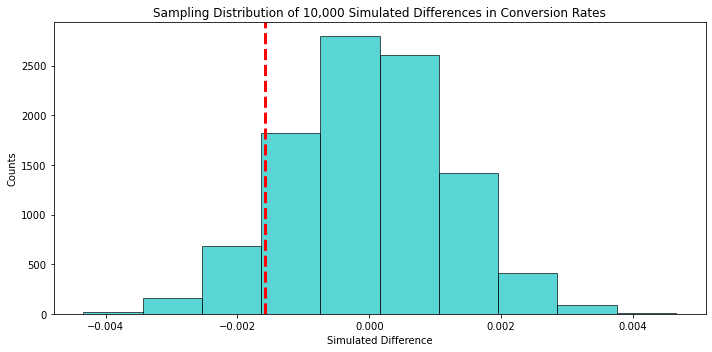

In [69]:
# observed difference in conversion rates
p_diffs_obs = convert_prob_treatment - convert_prob_control
print(f"Observed difference in conversion rates: {p_diffs_obs}\n\n")

# plot histogram
plt.figure(figsize=(10,5))
plt.hist(p_diffs_sim, color='c', edgecolor='k', alpha=0.65)
plt.title("Sampling Distribution of 10,000 Simulated Differences in Conversion Rates")
plt.axvline(p_diffs_obs, color='r', linestyle='dashed', linewidth=3)
plt.xlabel("Simulated Difference")
plt.ylabel("Counts")
plt.tight_layout()

In [80]:
# proportion of simulated samples where the difference is greater than the observed 
# difference on both sides
p_diffs_extreme = [abs(x) for x in p_diffs_sim ] > abs(p_diffs_obs)
print(f"Proportion of samples where the difference is greater than the observed differece: {np.mean(p_diffs_extreme)}")

Proportion of samples where the difference is greater than the observed differece: 0.187


In [91]:
# use Python's built in modules to obtain the statistics
convert_old = convert_prob_control * n_old
convert_new = convert_prob_treatment * n_new
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new],alternative='two-sided')
print(f"Z score: {z_score}")
print(f"P value: {p_value}")

Z score: 1.3109241984234394
P value: 0.18988337448195103


#### 4.4 Inference

Since the p-value is greater than 0.05, we reject the null hypothesis. In other words, 18.9% of the differences are as extreme as the observed difference. Therefore, at a type 1 error rate (alpha) of 5%, we can conclude that the new page and old page are not statistically different in converting users to enroll in the free program

### 5. Regression Approach

Logistic regression is performed to confirm the results obtained previously

#### 5.1 Logistic Regression

In [107]:
# create dummy variables from the group column
# column ab_page should be 1 when an individual receives the treatment, 0 otherwise
df2[['control','ab_page']] = pd.get_dummies(df2['group'])

# drop the control column
df2.drop('control', axis=1, inplace=True)

# create intercept column
df2['intercept'] = 1

# check to make sure the columns are added and to compare with old df2
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1


In [108]:
# instantiate regression model on the two columns - converted and ab_page
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])

# fit the model
results = log_mod.fit()
print(results.summary2())

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2022-05-20 00:02 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899

In [115]:
# likelihood
lik = np.exp(-0.015)

print(f"The new page is {round(lik*100, 2)}% as likely to convert users as the old page. In \
other words, the new page is {round((1-lik)*100, 2)}% less likely to convert users as the old page")

The new page is 98.51% as likely to convert users as the old page. In other words, the new page is 1.49% less likely to convert users as the old page


#### 5.2 Inference

* All the logistic regression model is doing is check whether there is a statistically significant difference in the conversion rate between the pages. (2-tail). (It calculates the observed difference internally)

* Since the p value is greater than 0.05, we fail to reject the null and can conclude that there is a statistically significant difference in the conversion rates between the two pages

### 6. Influence of Other factors

Here, we test the effect that the country that a user lives in, has on the conversion rate

#### 6.1 Logistic Regression

In [124]:
# read in countries dataset
df3 = pd.read_csv('data/part1_countries.csv')
df3.head()

# create dummy columns for country
df3[['CA','UK', 'US']] = pd.get_dummies(df3['country'])
# drop the country column since this is not necessary
df3.drop('country', axis=1, inplace=True)
df3.head()

# merge the countries dataframe with the current users dataframe
new_df = df2.merge(df3, on='user_id')
new_df.head()

# combine conversion and country
new_df['US_ab_page'] = new_df['US'] * new_df['ab_page']
new_df['UK_ab_page'] = new_df['UK'] * new_df['ab_page']
new_df['CA_ab_page'] = new_df['CA'] * new_df['ab_page']
print(new_df.head())

   user_id                   timestamp      group landing_page  converted  \
0   851104  2017-01-21 22:11:48.556739    control     old_page          0   
1   804228  2017-01-12 08:01:45.159739    control     old_page          0   
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0   
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0   
4   864975  2017-01-21 01:52:26.210827    control     old_page          1   

   ab_page  intercept  CA  UK  US  US_ab_page  UK_ab_page  CA_ab_page  
0        0          1   0   0   1           0           0           0  
1        0          1   0   0   1           0           0           0  
2        1          1   0   0   1           1           0           0  
3        1          1   0   0   1           1           0           0  
4        0          1   0   0   1           0           0           0  


In [126]:
# fit the regression model
log_mod2 = sm.Logit(new_df['converted'], new_df[['intercept', 'US_ab_page', 'UK_ab_page', 'CA_ab_page']])
results2 = log_mod2.fit()
results2.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212778.9383
Date:               2022-05-20 00:22 BIC:              212821.2568
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.067853   
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
US_ab_page   -0.0183    0.0126    -1.4486  0.1475  -0.0430   0.0064
UK_ab_page    0.0074    0.0180     0.4098  0.6819  -0.0279   0.0427
CA_ab_page   -0.0827    0.0380    -2.1763  0.0295  -0.1571  -0.0082
==================================================================

"""

In [128]:
# likelihood
np.exp(results2.params)

intercept     0.136863
US_ab_page    0.981901
UK_ab_page    1.007417
CA_ab_page    0.920649
dtype: float64

#### 6.2 Inference
    
Taking into account the country a particular user lives in, the p-value of the interactive term CA_ab_page was 0.0295, thereby suggesting that for residents of Canada, there is a statistically significant difference in conversion rates between the old and new pages. The new page is about 8% less likely to convert users compared to the old page. For US and UK residents, a statistically signifcant difference in conversion rates does not exist.

### 7. Recommendation and Conclusion

* Based on the analysis of the AB test results using different techniques like z-test and regression, it can be concluded that the difference in percentage of users enrolling in the free trial of the data science program between the new and old web page is not statistically significant. 

* When the influence of the countries that the users resided in was taken into account, the difference was not statistically different for UK and US. For Canada however, it was observed that the new web page is about 8% less likely to convert users compared to the old page. 

* Based on these results, the recommendation to the e-commerce company is to not launch the new web page